In [ ]:
Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

Objective: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

Dataset: This lab utilizes the Amazon UK product dataset which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

Crosstab Analysis:

Create a crosstab between the product category and the isBestSeller status.

Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the 
categories based on this proportion in descending order.

Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
Compute Cramér's V to understand the strength of association between best-seller status and category.
Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


%matplotlib inline

df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

#initial exploration
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [4]:
# Frequency table for category and bestseller
crosstab_BS = pd.crosstab(df['category'], df['isBestSeller'])

# Calculate the percentage of best-sellers per category
crosstab_BS['bestseller_percentage'] = crosstab_BS[True] / crosstab_BS.sum(axis=1) * 100

#Sort by percentage
bestseller_percent_sorted = crosstab_BS[['bestseller_percentage']].sort_values(by='bestseller_percentage', ascending=False)

#round 
bestseller_percent_sorted = bestseller_percent_sorted.round(2)

# Display
print(bestseller_percent_sorted.head())

isBestSeller                    bestseller_percentage
category                                             
Grocery                                          5.81
Smart Home Security & Lighting                   5.77
Health & Personal Care                           5.77
Mobile Phone Accessories                         4.25
Power & Hand Tools                               3.53


In [5]:
#  Calculate the percentage of best-sellers per category
bestseller_percentage = df.groupby('category')['isBestSeller'].mean() * 100

# Sort in descending order
bestseller_percentage_sorted = bestseller_percentage.sort_values(ascending=False)

# Clean
bestseller_df = bestseller_percentage_sorted.reset_index().rename(columns={'isBestSeller': 'bestseller_percentage'})
bestseller_df['bestseller_percentage'] = bestseller_df['bestseller_percentage'].round(2)

# Display
print(bestseller_df.head())

                         category  bestseller_percentage
0                         Grocery                   5.81
1  Smart Home Security & Lighting                   5.77
2          Health & Personal Care                   5.77
3        Mobile Phone Accessories                   4.25
4              Power & Hand Tools                   3.53


In [ ]:
#We can see that you are prevalent being in the best seller section being the grocery or Smart Home 
#Security & Lighting or Health & Personal Care category.

In [6]:
from scipy.stats import chi2_contingency
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_BS)
chi2_statistic, chi2_p_value

(50603.56501614783, 0.0)

In [7]:
#In a chi2, we assume that the two column that we compare are independent : That's the H0.
#If p-value is too low, we would reject H0, meaning the two column are dependent.
#Otherwise we accept H0.
#Then, if H0 is rejected, we want to know the strengh of that relation by using Cramer.

#Here, chi2_p_value is lower than 0.05 so we reject H0 : BestSeller and category are dependent.
#We use Cramer to assess teh strength

crosstab_BS2 = pd.crosstab(df['category'], df['isBestSeller'])

from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_BS2, method="cramer")

0.1222829439760564

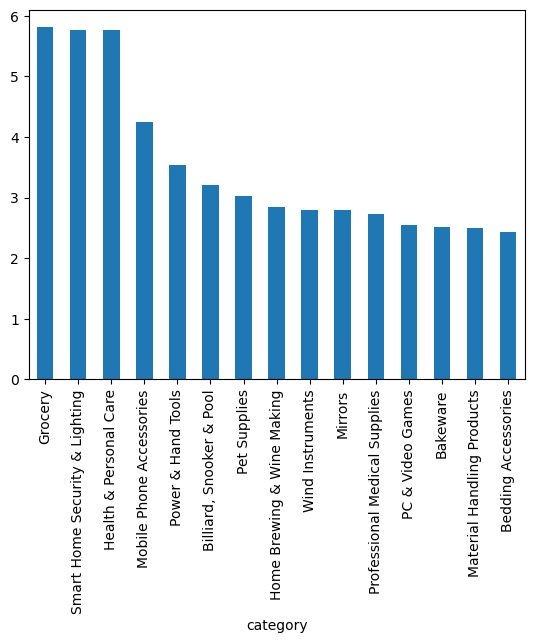

In [36]:
#We can see here that Cramer's V is low, really close to 0, which means that the relation between category and
# bestseller is weak.
Visualizations:

#Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

top15 = bestseller_percentage_sorted.head(15)
top15.plot(kind="bar", stacked=True)
plt.show()

In [8]:
#Part 2: Exploring Product Prices and Ratings Across Categories and Brands
#Objective: Investigate how different product categories influence product prices.

#Preliminary Step: Remove outliers in product prices.

#For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the 
#third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe 
#without outliers.

#Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for 
#a hint on how to do this.

def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers
    
data_series = df['price']  # replace 'ColumnName' with your specific column
outliers = tukeys_test_outliers(data_series)
print(outliers)
df_no_outliers = df.iloc[~outliers.index,:]


10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64


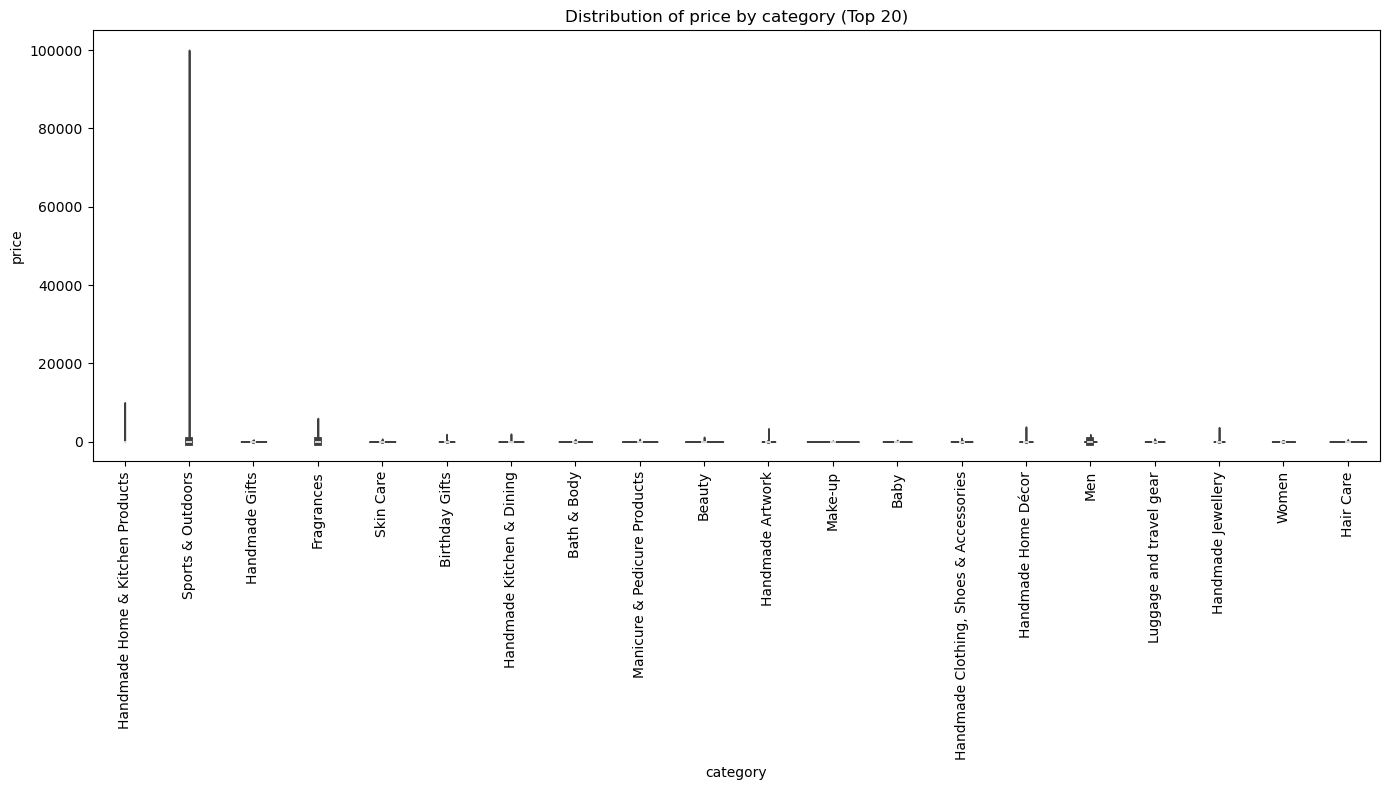

In [9]:
#Violin Plots:

#Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based 
#on count for better visualization.
#Which product category tends to have the highest median price? Don't filter here by top categories.

top_categories = df['category'].value_counts().nlargest(20).index

df_top = df[df['category'].isin(top_categories)]


plt.figure(figsize=(14, 8))
sns.violinplot(data=df_top, x='category', y='price')
plt.xticks(rotation=90)
plt.title('Distribution of price by category (Top 20)')
plt.tight_layout()
plt.show()

In [10]:
median_prices = df.groupby('category')['price'].median()
highest_median_category = median_prices.idxmax()
highest_median_value = median_prices.max()

print(f'The category with the highest median is : {highest_median_category} with a median of {highest_median_value}.')

The category with the highest median is : Laptops with a median of 1042.725.


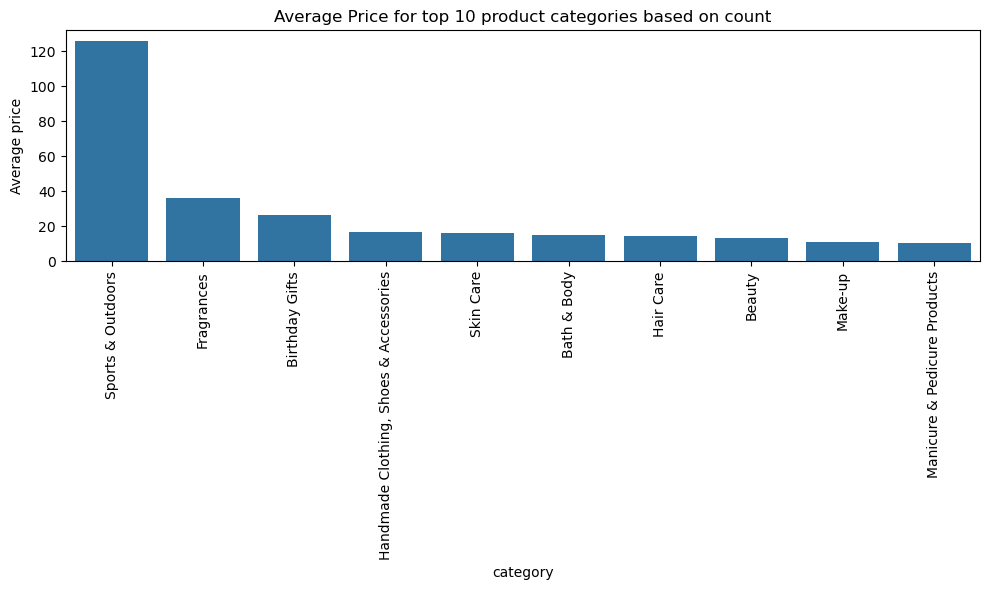

In [13]:
#Bar Charts:

#Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
#Which product category commands the highest average price? Don't filter here by top categories.

top_categories_10 = df['category'].value_counts().nlargest(10).index
df_top_10 = df[df['category'].isin(top_categories_10)]

avg_prices_top10 = df_top_10.groupby('category')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_prices_top10.index, y=avg_prices_top10.values)
plt.xticks(rotation=90)
plt.ylabel("Average price")
plt.title("Average Price for top 10 product categories based on count")
plt.tight_layout()
plt.show()


C:\Users\jtrin\AppData\Local\Temp\ipykernel_6360\1233293545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_10, x='category', y='stars', palette="coolwarm", legend=False);


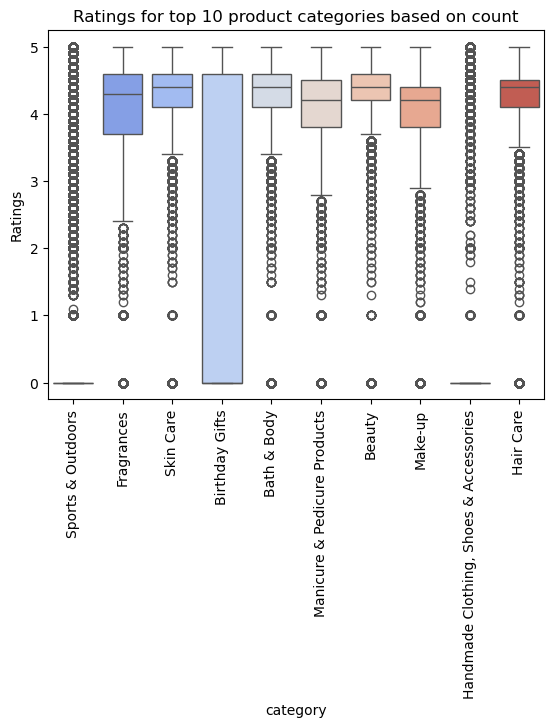

In [17]:
#Box Plots:
#Visualize the distribution of product ratings based on their category using side-by-side box plots. 
#Filter out the top 10 categories based on count for better visualization.
#Which category tends to receive the highest median rating from customers? Don't filter here by top categories.
#Part 3: Investigating the Interplay Between Product Prices and Ratings
#Objective: Analyze how product ratings (stars) correlate with product prices.

sns.boxplot(data=df_top_10, x='category', y='stars', palette="coolwarm", legend=False);
plt.xticks(rotation=90)
plt.ylabel("Ratings")
plt.title("Ratings for top 10 product categories based on count")
plt.show()


In [20]:
median_ratings = df.groupby('category')['stars'].median()
highest_median_category = median_ratings.idxmax()
highest_median_ratings = median_ratings.max()

print(f'The category with the highest median is : {highest_median_category} with a median of {highest_median_ratings}.')

The category with the highest median is : Computer Memory with a median of 4.7.


In [23]:
#Correlation Coefficients:

#Calculate the correlation coefficient between price and stars.
#Is there a significant correlation between product price and its rating?

correlation_1 = df['price'].corr(df['stars'])
correlation_2 = df['price'].corr(df['stars'], method='spearman')

print(f' Pearson correlation : {correlation_1:.3f} and Spearman correlation : {correlation_2:.3f}')

#A really weak connection between price and ratings because we have a correlation at negative 0.133.

 Pearson correlation : -0.125 and Spearman correlation : -0.133


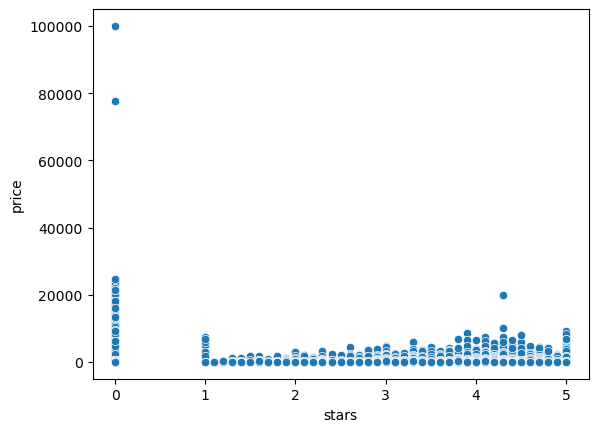

In [24]:
#Visualizations:
#Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
#Use a correlation heatmap to visualize correlations between all numerical variables.
#Examine if product prices typically follow a normal distribution using a QQ plot.

sns.scatterplot(data=df, x='stars', y='price');
plt.show()



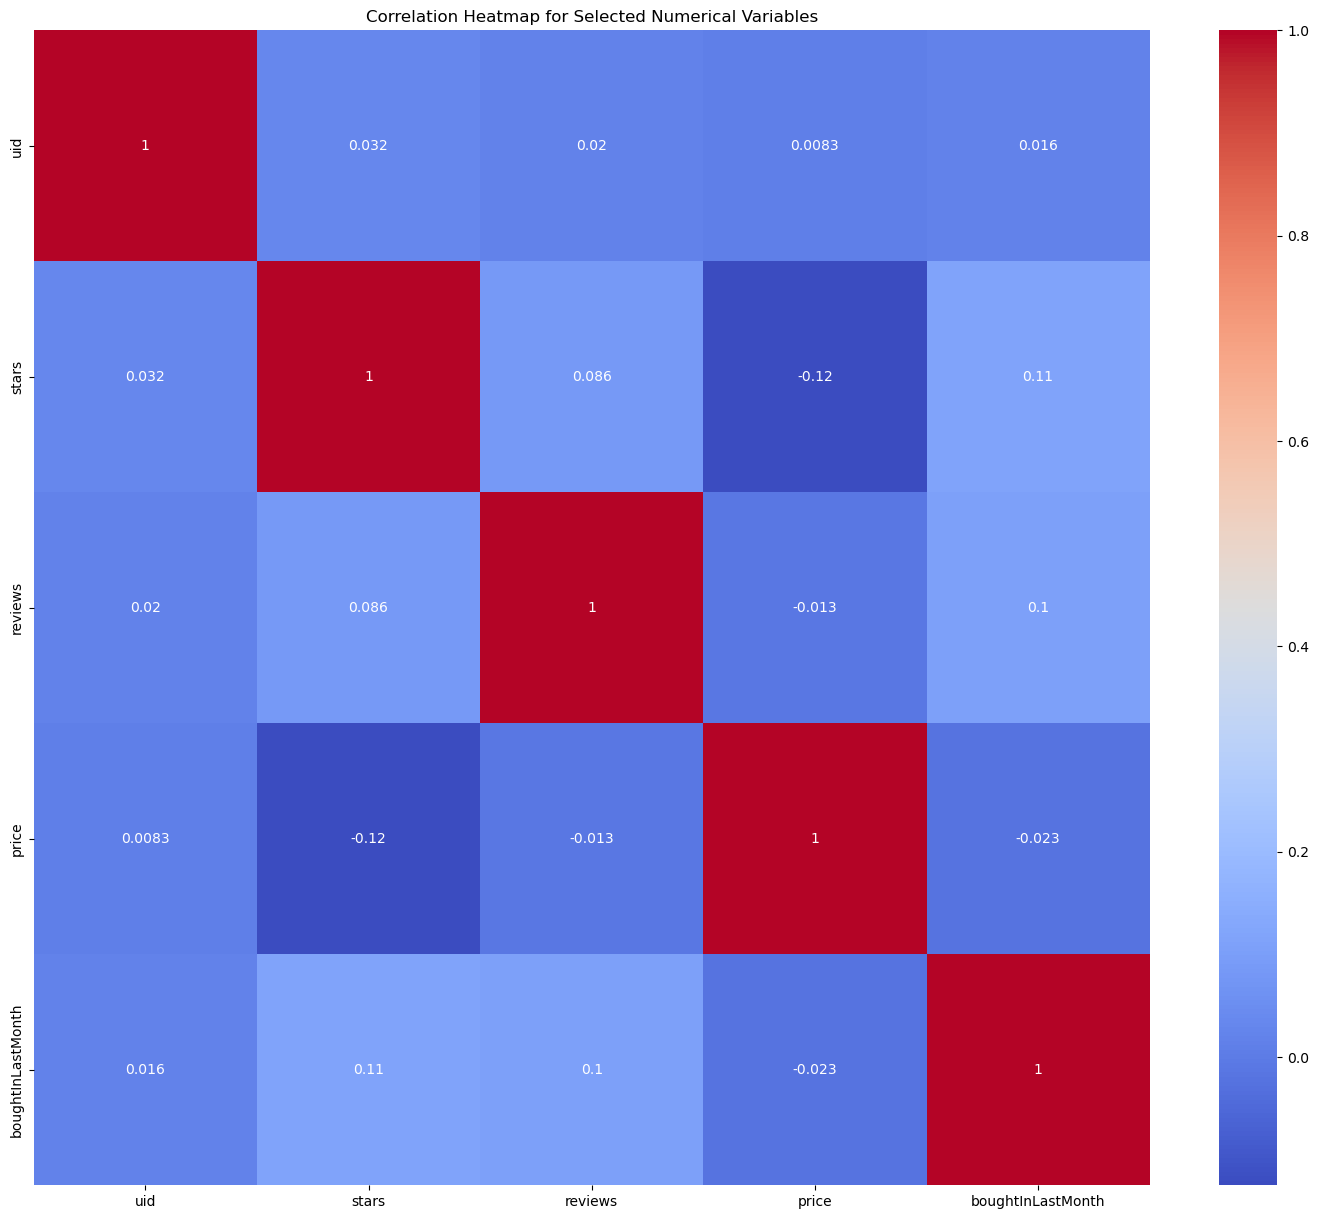

In [25]:
potential_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20]
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

correlation_matrix = df_numerical.corr()

plt.figure(figsize=(18, 15))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()


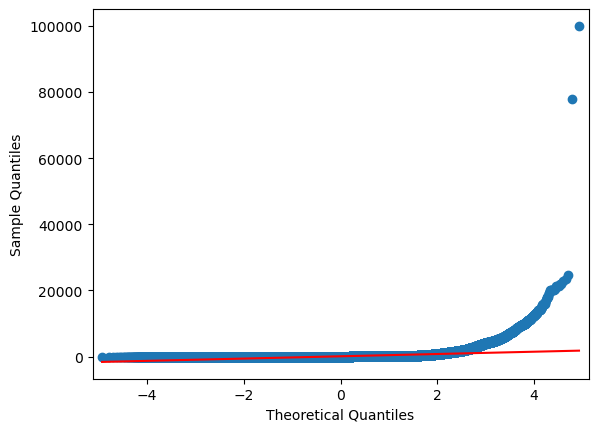

In [27]:
import statsmodels.api as sm

sm.qqplot(df['price'], line='s');
plt.show()

In [ ]:
#We can see a deviation from the normal distribution for the price product.